# Spawning classes

This and other notebooks for this video series are found at 

https://github.com/vathes/db-programming-with-datajoint

This notebook describes how to work with database schemas without access to the original code that generated the schema. These situations often arise when the database is created by another user who has not shared the generating code yet or when the database schema is created from a programming language other than Python. 

In [1]:
import datajoint as dj

## Working with schemas and their modules

Typically a DataJoint schema is created as a dedicated Python module. This module defines a `schema` object that is used to link classes declared in the module to tables in the database schema. As an example, examine the `university` module in this folder (`./university.py`).

You may then import the module to interact with its tables:

In [2]:
import university as uni

Connecting dimitri@localhost:3306


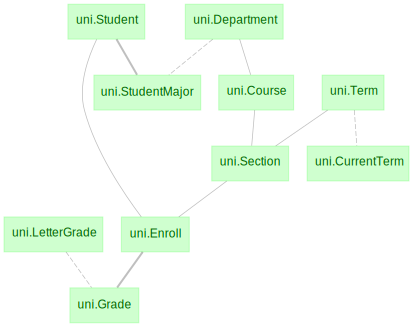

In [3]:
dj.Diagram(uni)

Note that `dj.Diagram` can extract the diagram from a schema object or from a python module containing its `schema` object, lending further support to the convention of one-to-one correspondence between database schemas and Python modules in a datajoint project:
```python
dj.Diagram(uni)
```
is equvalent to 
```python
dj.Diagram(uni.schema)
```

In [4]:
# students without majors 
uni.Student - uni.StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1003,Jonathan,Wilson,M,2002-10-19,91101 Summer Park,Port Jacqueline,VT,75616,982.251.1567x21450
1005,Richard,Lopez,M,1993-10-16,86210 Brooks Station,West David,IL,96184,+1-385-481-6761x1575
1006,Laura,Hammond,F,1984-12-03,0346 Shannon Motorway,East David,ME,22113,(189)406-2652x143


## Spawning missing classes
Now imagine that you do not have access to `university.py` or you do not have its latest version. You can still connect to the database schema but you will not have classes declared to interact with it.

So let's start over in this scenario.

### <font color="green">**!!! Restart the kernel here to remove the previous class definitions !!!**</font>

You can may use the `dj.list_schemas` function (new in `datajoint 0.12.0`) to list the names of database schemas available to you.

In [1]:
import datajoint as dj
dj.list_schemas()

Connecting dimitri@localhost:3306


['dimitri_alter',
 'dimitri_attach',
 'dimitri_blob',
 'dimitri_blobs',
 'dimitri_nphoton',
 'dimitri_schema',
 'dimitri_university',
 'dimitri_uuid',
 'university']

Just as with a new schema, we start by creating a `schema` object to connect to the chosen database schema:

In [2]:
schema = dj.schema('dimitri_university')

If the schema already exists, `dj.schema` is initialized as usual and you may plot the schema diagram. But instead of seeing class names, you will see the raw table names as they appear in the database.

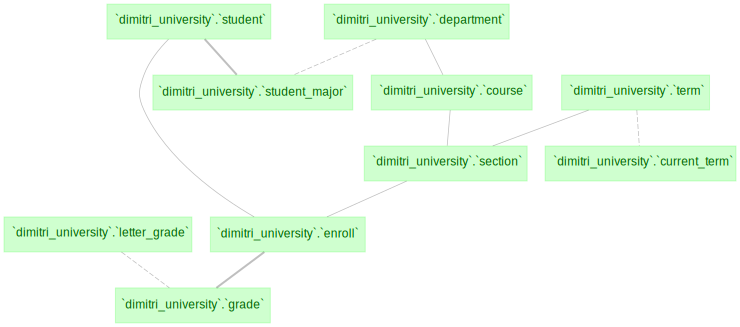

In [3]:
# let's plot its diagram
dj.Diagram(schema)

You may view the diagram but, at this point, there is now way to interact with these tables. A similar situation arises when another developer has added new tables to the schema but has not yet shared the updated module code with you. Then the diagram will show a mixture of class names and database table names.

Now you may use the `schema.spawn_missing_classes` method to *spawn* classes into the local namespace for any tables missing their classes:

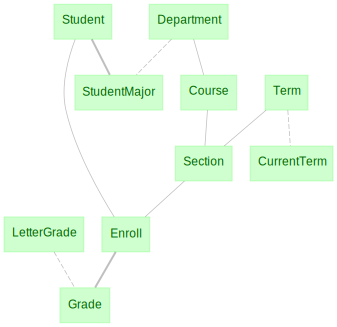

In [4]:
schema.spawn_missing_classes()
dj.Di(schema)

Now you may interact with these tables as if they were declared right here in this namespace:

In [5]:
# students without majors 
Student - StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1003,Jonathan,Wilson,M,2002-10-19,91101 Summer Park,Port Jacqueline,VT,75616,982.251.1567x21450
1005,Richard,Lopez,M,1993-10-16,86210 Brooks Station,West David,IL,96184,+1-385-481-6761x1575
1006,Laura,Hammond,F,1984-12-03,0346 Shannon Motorway,East David,ME,22113,(189)406-2652x143


### <font color="green">**!!! Restart the kernel here to remove the previous class definitions !!!**</font>

# Creating a virtual module
Now `spawn_missing_classes` creates the new classes in the local namespace. However, it is often more convenient to import a schema with its python module, equivalent to the python the python command 
```python
import university as uni
```

We can mimick this import without having access to `university.py` using the `create_virtual_module` function:

In [1]:
import datajoint as dj

uni = dj.create_virtual_module('university', 'dimitri_university')

Connecting dimitri@localhost:3306


Now `uni` behaves as an imported module complete with the `schema` object and all the table classes.

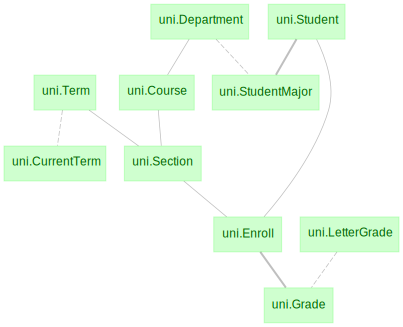

In [2]:
dj.Di(uni)

In [3]:
uni.Student - uni.StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
1003,Jonathan,Wilson,M,2002-10-19,91101 Summer Park,Port Jacqueline,VT,75616,982.251.1567x21450
1005,Richard,Lopez,M,1993-10-16,86210 Brooks Station,West David,IL,96184,+1-385-481-6761x1575
1006,Laura,Hammond,F,1984-12-03,0346 Shannon Motorway,East David,ME,22113,(189)406-2652x143


`dj.create_virtual_module` takes optional arguments. 

First, `create_schema=False` assures that an error is raised when the schema does not already exist. Set it to `True` if you want to create an empty schema.

In [4]:
dj.create_virtual_module('what', 'nonexistent')

DataJointError: Database named `nonexistent` was not defined. Set argument create_schema=True to create it.

The other optional argument, `create_tables=False` is passed to the `schema` object. It prevents the use of the `schema` obect of the virtual module for creating new tables in the existing schema. This is a precautionary measure since virtual modules are often used for completed schemas. You may set this argument to `True` if you wish to add new tables to the existing schema. A more common approach in this scenario would be to create a new `schema` object and to use the `spawn_missing_classes` function to make the classes available.

However, you if do decide to create new tables in an existing tables using the virtual module, you may do so by using the schema object from the module as the decorator for declaring new tables:

In [6]:
uni = dj.create_virtual_module('university.py', 'dimitri_university', create_tables=True)

In [7]:
@uni.schema
class Example(dj.Manual):
    definition = """
    -> uni.Student 
    ---
    example : varchar(255)
    """

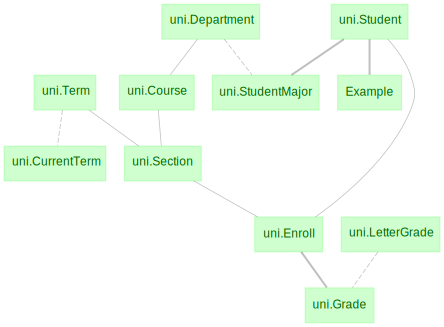

In [8]:
dj.Di(uni)

In [14]:
uni.Enroll.describe();

-> uni.Student
-> uni.Section



In [ ]:
uni.save()